In [ ]:
import numpy as np
import pandas as pd
import datetime as dt
import yfinance as yf
def getData(stocks,start,end):
    stockData = yf.download(stocks,start = start, end = end)
    return stockData
stockList = ['NVDA','MSFT','LRCX','AAPL','AMZN','GOOGL','AMAT','MA','ZM','V']
endDate = dt.datetime.now()
startDate = endDate - dt.timedelta(days = 1000)

In [5]:
df = getData(stockList,start = startDate, end = endDate)
df = df['Adj Close']
ret = df.pct_change()

[*********************100%***********************]  10 of 10 completed


In [16]:
mean_ret = ret.mean()
std_ret = ret.cov()

In [19]:
def count_trading_days(start_date, end_date):
    trading_days = pd.date_range(start=start_date, end=end_date, freq='B')
    return len(trading_days)
trading = count_trading_days('2020-10-22','2023-07-18')

In [35]:
def portfolioPerformance(weights,meanReturns,covMatrix):
    returns = np.sum(meanReturns*weights)*trading
    std = np.sqrt(np.dot(weights.T,np.dot(covMatrix,weights)))*np.sqrt(trading)
    return np.round(returns,3),np.round(std,3)

In [36]:
weights = np.array([1/len(stockList) for _ in range(len(stockList))])
returns,std = portfolioPerformance(weights,mean_ret,std_ret)

In [208]:
def portfolioVariance(weights, meanReturns, covMatrix):
    return portfolioPerformance(weights, meanReturns, covMatrix)[1]
def minimizeVariance(meanReturns, covMatrix, riskFreeRate = 0, constraintSet = (0,1)):
    numAssets = len(meanReturns)
    args = (meanReturns, covMatrix)
    constraints = ({'type': 'eq', 'fun':lambda x: np.sum(x)-1})
    bound = constraintSet
    bounds = tuple(bound for _ in range(numAssets))
    ws = [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
    result = sc.minimize(portfolioVariance,ws,args = args,
                        method = 'SLSQP', bounds = bounds, constraints = constraints)
    return result

In [209]:
minVarResult = minimizeVariance(mean_ret, std_ret)
minVar, minVarWeights = minVarResult['fun'],minVarResult['x']
print(minVar,minVarWeights)

0.503 [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]


In [210]:
# Regularization parameter (lambda)
lambda_ = 0.07  # You can adjust this value to control the strength of the regularization
maxSRResult = maxSR(mean_ret, std_ret, lambda_)
maxSR, maxSRWeights = maxSRResult['fun'],maxSRResult['x']
print("Optimized Portfolio Sharpe with L2 Regularization: ")
print(-maxSR)
print("Optimized Portfolio Weights with L2 Regularization: ")
print(np.round(maxSRWeights,3))

Optimized Portfolio Sharpe with L2 Regularization: 
1.5903776273857453
Optimized Portfolio Weights with L2 Regularization: 
[0.1  0.1  0.1  0.1  0.14 0.01 0.15 0.2  0.1  0.  ]


In [227]:
import scipy.optimize as sc
riskFreeRate = 0
def negativeSR(weights,meanReturns,covMatrix, lambda_=0):
    pReturns, pStd = portfolioPerformance(weights,mean_ret,std_ret)
    sharpeRatio = (pReturns-riskFreeRate)/pStd
    # Add L2 regularization term
    l2_reg = lambda_ * np.sum(np.square(weights))
    return -sharpeRatio + l2_reg
constraintSet = (0,1)
def maxSR(meanReturns, covMatrix,lambda_= 0):
    numAssets = len(meanReturns)
    args = (meanReturns, covMatrix)
    constraints = ({'type': 'eq', 'fun':lambda x: np.sum(x)-1})
    bound = constraintSet
    bounds = tuple(bound for _ in range(numAssets))
    ws = [0.1, 0.1, 0.1, 0.1, 0.14, 0.01, 0.15, 0.2, 0.1, 0]
    result = sc.minimize(negativeSR, ws, args=(meanReturns, covMatrix, lambda_),
                         method='SLSQP', bounds=bounds, constraints=constraints, options={'disp': False})
    return result


def calculatedResult(meanReturn,covMatrix,riskFreeRate = 0, constraintSet = (0,1),lambda_=0.03):
    maxSR_portfolio = maxSR(meanReturn, covMatrix, lambda_)
    maxSR_ret,maxSR_std = portfolioPerformance(maxSR_portfolio['x'],meanReturn, covMatrix)
    maxSR_allocation = pd.DataFrame(maxSR_portfolio['x'], index = meanReturn.index,
                                    columns = ['allocation'])
    maxSR_allocation.allocation = [round(i*100,0) for i in maxSR_allocation.allocation]
    minVol_portfolio = minimizeVariance(meanReturn, covMatrix)
    minVol_ret,minVol_std = portfolioPerformance(minVol_portfolio['x'],meanReturn, covMatrix)
    minVol_allocation = pd.DataFrame(minVol_portfolio['x'], index = meanReturn.index,
                                    columns = ['allocation'])
    minVol_allocation.allocation = [round(i*100,0) for i in minVol_allocation.allocation]
    #Efficient frontier
    efficientList = []
    targetReturns = np.linspace(minVol_ret, maxSR_ret,20)
    for target in targetReturns:
        efficientList.append(efficientOpt(meanReturn, covMatrix, target)['fun'])
    return maxSR_ret, maxSR_std, maxSR_allocation, minVol_ret, minVol_std, minVol_allocation,efficientList
print(calculatedResult(mean_ret,std_ret))

(0.867, 0.542,        allocation
AAPL         10.0
AMAT         10.0
AMZN         10.0
GOOGL        10.0
LRCX         14.0
MA            1.0
MSFT         15.0
NVDA         20.0
V            10.0
ZM            0.0, 0.491, 0.503,        allocation
AAPL         10.0
AMAT         10.0
AMZN         10.0
GOOGL        10.0
LRCX         10.0
MA           10.0
MSFT         10.0
NVDA         10.0
V            10.0
ZM           10.0, [0.503, 0.503, 0.503, 0.503, 0.503, 0.503, 0.503, 0.503, 0.503, 0.503, 0.503, 0.503, 0.503, 0.503, 0.503, 0.503, 0.503, 0.503, 0.503, 0.503])


In [222]:
def portfolioReturn(weights, meanReturns, covMatrix):
    return portfolioPerformance(weights, meanReturns, covMatrix)[0]
def efficientOpt(meanReturns, covMatrix, returnTarget, constraintSet = (0,1)):
    numAssets = len(meanReturns)
    args = (meanReturns,covMatrix)
    constraints = ({'type':'eq', 'fun': lambda x: portfolioReturn(x, meanReturns, covMatrix) - returnTarget},
                  {'type':'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple(constraintSet for _ in range(numAssets))
    effOpt = sc.minimize(portfolioVariance,numAssets*[1./numAssets],args = args,
                        method = 'SLSQP', bounds = bounds, constraints = constraints)
    return effOpt
print(efficientOpt(mean_ret,std_ret,0.4))

     fun: 0.503
     jac: array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
 message: 'Singular matrix C in LSQ subproblem'
    nfev: 11
     nit: 1
    njev: 1
  status: 6
 success: False
       x: array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])


In [221]:
from pypfopt import expected_returns, risk_models, objective_functions, EfficientFrontier, objective_functions, CLA
from scipy.optimize import minimize
from scipy.stats import norm
import matplotlib.pyplot as plt

In [93]:
# Define constraints
bounds = [(0,1) for i in range(len(stockList))]
# Define optimization constraints
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
# Define risk management parameters
max_drawdown = 0.4
volatility_target = 0.4
cvar_alpha = 0.01
gamma = 0.01
alpha = 0.01
from scipy.optimize import minimize
# Define optimization problem
def objective_function(w, mu, Sigma, gamma, alpha, max_drawdown, volatility_target, cvar_alpha):
    # Calculate portfolio returns and risk
    portfolio_return = np.dot(w, mu)
    portfolio_volatility = np.sqrt(np.dot(w.T, np.dot(Sigma, w)))
    # Calculate portfolio drawdown
    portfolio_drawdown = max_drawdown - np.max(np.maximum.accumulate(portfolio_return.cumsum()) - portfolio_return.cumsum())
    # Calculate portfolio CVaR
    def calculate_cvar(weights, mu, Sigma, alpha):
    # Calculate the portfolio return and standard deviation
        port_return = np.dot(mu.T, weights)
        port_std_dev = np.sqrt(np.dot(weights.T, np.dot(Sigma, weights)))
    
    # Calculate the VaR at the given alpha level
        z_alpha = norm.ppf(alpha)
        VaR = -(port_return - z_alpha * port_std_dev)
    
    # Calculate the CVaR at the given alpha level
        cvar = -((1 / alpha) * norm.pdf(z_alpha)) * port_std_dev + VaR
    
        return cvar/8000
    portfolio_cvar = calculate_cvar(w, mu, Sigma, cvar_alpha)
    # Calculate penalty terms
    volatility_penalty = gamma * np.square(portfolio_volatility - volatility_target)
    drawdown_penalty = alpha * np.square(portfolio_drawdown)
    
    # Calculate objective function
    obj = -portfolio_return+ volatility_penalty + drawdown_penalty + portfolio_cvar
    return obj

# Optimize portfolio with risk management
result = minimize(objective_function, weights, args=(mean_ret, std_ret, gamma, alpha, max_drawdown, volatility_target, cvar_alpha), 
                  method='SLSQP', constraints=constraints, bounds=bounds)

# Extract optimized portfolio weights
optimized_weights = result.x
optimized_weights

array([2.33417949e-16, 2.20235546e-01, 1.23416979e-16, 1.56530380e-16,
       1.11022302e-16, 0.00000000e+00, 4.36353133e-16, 7.79764454e-01,
       0.00000000e+00, 0.00000000e+00])

In [94]:
ret.drop(['portfolio'],axis=1,inplace=True)
ret['portfolio'] = (ret * optimized_weights).sum(axis=1)
level = (1+ret).cumprod()

In [95]:
level.tail(2)

,AAPL,AMAT,AMZN,GOOGL,LRCX,MA,MSFT,NVDA,V,ZM,portfolio
Date,,,,,,,,,,,
2023-07-17,1.703932,2.415922,0.840952,1.551666,1.903968,1.224309,1.649555,3.485633,1.256061,0.139932,3.323592
2023-07-18,1.701648,2.399483,0.836356,1.540587,1.892055,1.212011,1.715207,3.563132,1.239484,0.138856,3.376232


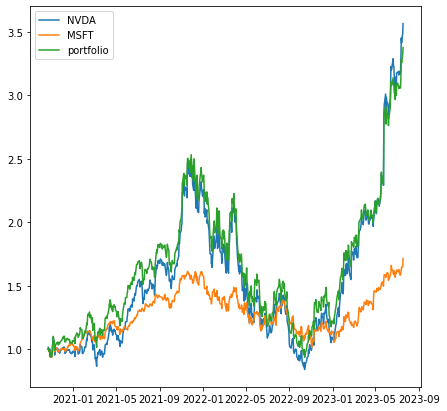

In [89]:
fig,axs = plt.subplots(figsize = (7,7))
axs.plot(level[['NVDA','MSFT','portfolio']],label = ['NVDA','MSFT','portfolio'])
axs.legend()
plt.show()